# Numerical Calculation of Magnetic Flux

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.integrate import dblquad

## Exercise (a)

Flux of a magnetic field in the $z$-direction through a square plate with sides $a$ in the $xy$-plane (centre at the origin). The strength of the magnetic field is given by the expression
\begin{align}
B(x, y)&=B_0\cdot\left(1-\frac{2\cdot(x^2+y^2)}{a^2}\right)
\end{align}

In [3]:
# Define the function for the magnetic field
# The default value for B0 is 1

def B(x, y, a, B0=1):
    return B0*(1-2*(x**2+y**2)/a**2)

In [42]:
# Define parameters

a_value = 0.1 # length of sides of rectangle

# The rectangle is divided into NxN small squares:
N = 2000
da = a_value/N # side of a small square
dA = da**2 # area of a small square

In [43]:
# Calculation of flux using for loops

# define lists of coordinates for centres of small squares
array_x = np.linspace(-a_value/2+da/2, a_value/2-da/2, N)
array_y = np.linspace(-a_value/2+da/2, a_value/2-da/2, N)

flux = 0 # initial value for flux

for x in array_x:
    for y in array_y:
        dflux = B(x, y, a_value, B0=0.2)*dA # calculate flux through small square at x, y
        flux += dflux # add flux to total flux

print(f'magnetic flux: {flux:.5f}')

magnetic flux: 0.00133


For large $N$ this version becomes very slow since the number of calculations increases like $N^2$. Using a *vectorised* version where the calculations are done in parallel turns out to be much faster. This can be achieved using the NumPy library.

In this case the vectorised version is more than 30 times faster!

In [45]:
# Calculation of flux using vectorization (numpy)

# define lists of coordinates for centres of small squares
array_x = np.linspace(-a_value/2+da/2, a_value/2-da/2, N)
array_y = np.linspace(-a_value/2+da/2, a_value/2-da/2, N)

x, y = np.meshgrid(array_x, array_y) # construct coordinate grid

flux_array = (B(x, y, a_value, B0=0.2)*dA) # calculate flux at each position
flux = flux_array.sum() # sum up all partial fluxes

print(f'magnetic flux: {flux:.5f}')

magnetic flux: 0.00133


## Exercise (b)

The flux of a magnetic field through a surface defined by the function
\begin{equation}
z(x, y)=z_\textrm{max}\cdot\left(1-\left(\frac{2\cdot x}{a}\right)^2\right)
\end{equation}
The surface is limited by the conditions $x\in [-a/2, a/2]$ and $y\in [-L/2, L/2]$, i.e. it has a width $a$ and a length $L$.

The magnetic field is given by the expression
\begin{equation}
\vec{B}=
\begin{pmatrix}\alpha\cdot x\\0\\B_0\cdot e^{-\beta\cdot z}
\end{pmatrix}
\end{equation}
The $x$-component linearly increases in the direction of the $x$-axis, i.e. the vector is tilted with respect to the $z$-axis (unless $x=0$). Its $z$-component has its reference value $B_0$ on the $xy$-plane and it decreases exponentially along the positive $z$-axis.

In [47]:
# Define the functions for the surface (extruded parabola) and the magnetic field

# The default value for zmax is 1
def parabola(x, y, a, zmax=1):
    return zmax*(1-(2*x/a)**2)

# The default values for alpha and beta are 1
def Bvec(x, y, z, a, L, B0=1, al=1, be=1):
    shape = x.shape
    return np.moveaxis(np.array([al*x, np.zeros(shape), B0*np.exp(-be*z)]), 0, -1)

    # The method np.moveaxis makes sure that we have an array of coordinate triplets


In [48]:
# Define parameters

a_value = 0.1 # width of surface
L_value = 0.2 # length of surface

Nx = 5000 # number of steps along x-axis
Ny = 5000 # number of steps along y-axis

dx = a_value/(Nx-1) # stepsize along x-axis
dy = L_value/(Ny-1) # stepsize along y-axis

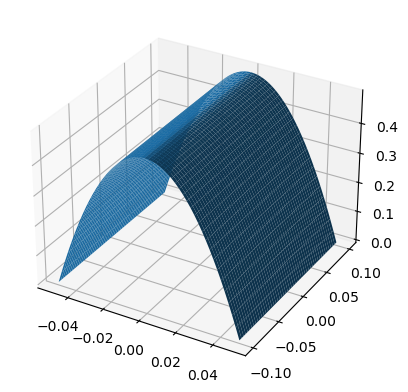

In [49]:
array_x = np.linspace(-a_value/2, a_value/2, Nx) # array with x-coordinates
array_y = np.linspace(-L_value/2, L_value/2, Ny) # array with y-coordinates

x, y = np.meshgrid(array_x, array_y) # define coordinate grid

z = parabola(x, y, a_value, zmax=0.5) # calculate height for x,y values

fig, ax = plt.subplots(subplot_kw={'projection': '3d'}) # define 3d plot
ax.plot_surface(x, y, z) # plot surface

For the calculation of the magnetic flux, we need to calculate the dot product between the magnetic field vector on a surface element and the normal to the surface at that position. The normal to the surface element is in a plane parallel to the $xz$-plane and perpendicular to the tangent to the parabole defining the surface.

We approximate the slope of the tangent as $\Delta z/\Delta x$, so the normal has a slope $-\Delta x/\Delta z$.

In [50]:
dz = np.diff(z, axis=1)[0] # calculate the values for \Delta z
nx = -dz/dx # component of normal in x-direction
ny = np.zeros(Nx-1) # component of normal in y-direction is zero
nz = np.ones(Nx-1) # component of normal in z-direction set to 1
n = np.moveaxis(np.array([nx, ny, nz]), 0, 1) # define array of normal vectors

# We define an array of vectors whose area is equal to the area of the surface element
# and whose direction is given by the normal at that position
dA = n * dx * dy
dA = np.reshape(dA, (1, Nx-1, 3))

# define positions to evaluate B-field
xB_array = array_x[1:] - dx/2
yB_array = array_y[1:] - dy/2

xB, yB = np.meshgrid(xB_array, yB_array) # xy coordinates to evaluate B-field
zB = parabola(xB, yB, a_value) # z coordinates to evaluate B-field

# calculate magnetic flux (vectorised)
dflux = (dA*Bvec(xB, yB, zB, a_value, L_value, al=0.5, B0=0.2, be=0.5))
flux = dflux.sum() # sum up partial fluxes

print(f'magnetic flux: {flux:.5f}')

magnetic flux: 0.00623
